<a href="https://colab.research.google.com/github/varsha2509/Springboard-DS/blob/master/Capstone2/Colab/DeepSat6_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install Packages and Mount Google Drive
import pandas as pd
import numpy as np
import cv2
import h5py
import csv
from scipy.io import loadmat
import matplotlib.pyplot as plt 
from google.colab import drive
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import balanced_accuracy_score


from skimage.io import imread

from glob import glob

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Springboard/Capstone Projects/Capstone-2/DeepSat-6-Dataset/"

#Mount the drive to colab notebook
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
#Change the current working directory
%cd /content/gdrive/My\ Drive/Springboard/Capstone\ Projects/Capstone-2/DeepSat-6-Dataset/


/content/gdrive/My Drive/Springboard/Capstone Projects/Capstone-2/DeepSat-6-Dataset


# Read input files

## Function to read subset of csv file, both train and test data

In [4]:
## Create a function to read 5000 rows from csv file

def read_csv_x_y(path, nrows = 5000):
  """ path can be 'X_train_sat6.csv, y_train,sat6.csv
      X_test_sat6.csv, y_test_sat6.csv"""
  input_df = pd.read_csv(path, nrows = nrows, header = None)
  X = input_df.values.reshape(-1, 28, 28, 4).clip(0,255).astype(np.uint8) #This moves the position of the last column to the first, and clips the RGB values between (0,255)
  y = np.argmax(pd.read_csv(path.replace('X_', 'y_'), nrows = nrows, header = None).values,1) #This determines the position or index where 1 appears, to map the categories to names

  return X, y


Xtrain, ytrain = read_csv_x_y('X_train_sat6.csv', 16)
print(ytrain.dtype)

print(Xtrain.shape, ytrain.shape)









int64
(16, 28, 28, 4) (16,)


In [5]:
## Read annotations
annotations = pd.read_csv('sat6annotations.csv', header = None)
annotations.head(10)

# #Create a dictionary with values as land categories
land_categories = dict()
for idx, an in enumerate(annotations[0]):
  land_categories[idx] = an
land_categories

{0: 'building',
 1: 'barren_land',
 2: 'trees',
 3: 'grassland',
 4: 'road',
 5: 'water'}

## Map test and train data with label names

In [6]:
#Map ytrain and ytest with label names
ytrain_cat = pd.DataFrame(ytrain)[0].map(land_categories)
#ytest_cat = pd.DataFrame(ytest).idxmax(axis=1).map(land_categories)

## Plot sample images

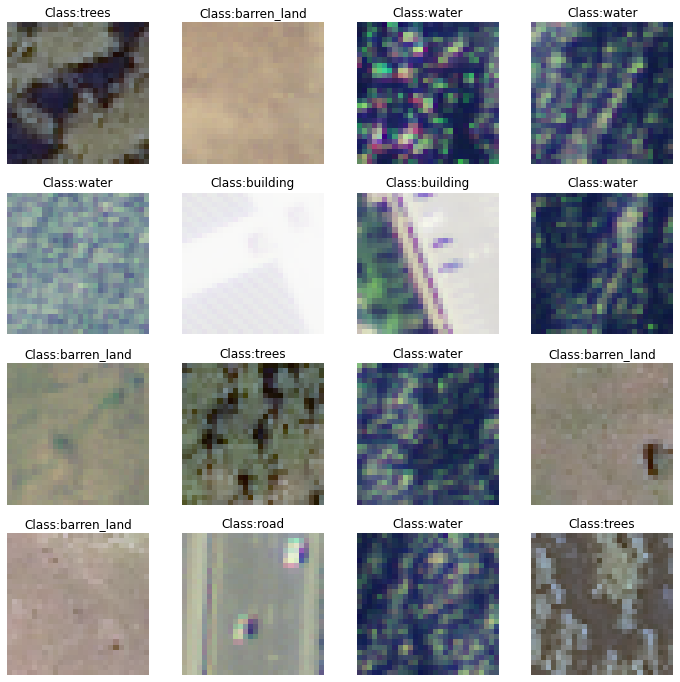

In [7]:
fig, ax = plt.subplots(4, Xtrain.shape[0]//4, figsize = (12, 12))
for (x, Y, c_ax) in zip(Xtrain, ytrain_cat, ax.flatten()):
    c_ax.imshow(x[:,:,:3], # 
                interpolation = 'none')
    c_ax.axis('off')
    c_ax.set_title('Class:{}'.format(Y))


#Training a Random Forest

In [8]:
Xtrain, ytrain = read_csv_x_y('X_train_sat6.csv', 20000)

In [9]:
#Map numbers to categories
ytrain_cat = pd.DataFrame(ytrain)[0].map(land_categories)

In [10]:
# Create a simple random forest model
clf  = RandomForestClassifier(n_estimators=100, max_depth = 10)

# Random forest model training
clf.fit(Xtrain.reshape((-1, np.prod(Xtrain.shape[1:]))), ytrain_cat)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
#Load the test data
Xtest, ytest = read_csv_x_y('X_test_sat6.csv', None)

In [12]:
#Map numbers to categories
ytest_cat = pd.DataFrame(ytest)[0].map(land_categories)

## Make predictions on test dataset

In [13]:
#Make predictions on Xtest
pred_Y =clf.predict(Xtest.reshape((-1, np.prod(Xtest.shape[1:]))))

## Classification Report, Accuracy and Confusion Matrix

In [14]:
#Print classification report
print(classification_report(ytest_cat, pred_Y))

              precision    recall  f1-score   support

 barren_land       0.97      0.94      0.96     18367
    building       0.91      0.95      0.93      3714
   grassland       0.89      0.84      0.87     12596
        road       0.90      0.65      0.75      2070
       trees       0.90      0.98      0.94     14185
       water       0.99      1.00      0.99     30068

    accuracy                           0.95     81000
   macro avg       0.93      0.89      0.91     81000
weighted avg       0.95      0.95      0.95     81000



In [15]:
#Print overall accuracy
print('Overall Accuracy: %2.2f%%'  % (100*accuracy_score(ytest_cat, pred_Y)))

Overall Accuracy: 94.77%


In [16]:
#Print Balanced accuracy
print('Balanced Accuracy: %2.2f%%' % (100*balanced_accuracy_score(ytest_cat, pred_Y)))

Balanced Accuracy: 89.43%


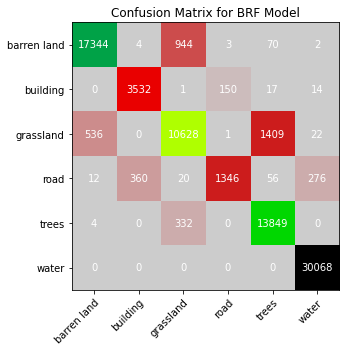

In [25]:
#Plot confusion matrix
cm = confusion_matrix(ytest_cat, pred_Y)

fig, ax = plt.subplots(figsize = (5,5))
im = ax.imshow(cm, cmap = plt.cm.nipy_spectral_r)

# We want to show all ticks...
ax.set_xticks(np.arange(len(land_categories)))
ax.set_yticks(np.arange(len(land_categories)))
# ... and label them with the respective list entries
ax.set_xticklabels(['barren land','building','grassland','road','trees','water'])
ax.set_yticklabels(['barren land','building','grassland','road','trees','water'])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion Matrix for BRF Model")
fig.tight_layout()
plt.show()

## Determine Prediction Errors

In [21]:
#Create dataframe to store actual and predicted categories
prediction_err  = pd.DataFrame()
prediction_err = prediction_err.append([ytest_cat, pred_Y]).T
prediction_err.columns = ['Actual','Predicted']

In [22]:
prediction_err.head()

,Actual,Predicted
0,trees,trees
1,trees,trees
2,water,water
3,barren_land,barren_land
4,water,water


In [23]:
#Determine mismatches by comapring both labels
pred_mismatch = prediction_err.loc[(prediction_err.Actual != prediction_err.Predicted)]
print('Overall total mismatches:' , (len(pred_mismatch)))

Overall total mismatches: 4233


In [24]:
#Create a dataframe of total mismatches using group by
mismatch_df = pred_mismatch.groupby(['Actual']).describe().reset_index()


#Drop columns that are not needed
mismatch_df = mismatch_df.drop(mismatch_df.columns[[2,4,3]], axis = 1)


##Rename columns
mismatch_df.columns = [('Class'), ('Total Mismatches')]

mismatch_df.head()

,Class,Total Mismatches
0,barren_land,1023
1,building,182
2,grassland,1968
3,road,724
4,trees,336
